In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 參考網站
[Kaggle post written by Yassine](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

In [2]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")
print('train shape: ', train.shape, ', test shape: ', test.shape)

train shape:  (891, 12) , test shape:  (418, 11)


## Outlier detection

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

D:\Anaconda3\envs\myenv\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
train_len = len(train)

## joining train and test set

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [7]:
# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature analysis

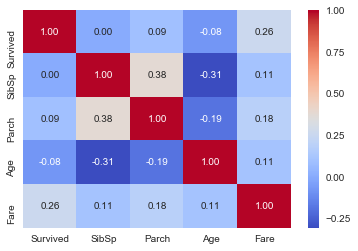

In [10]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

### Numerical values - SibSP

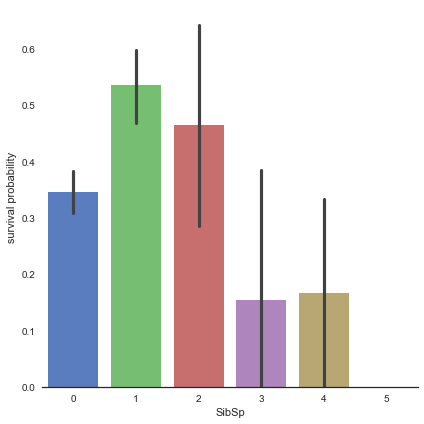

In [11]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

### Numerical values - Parch

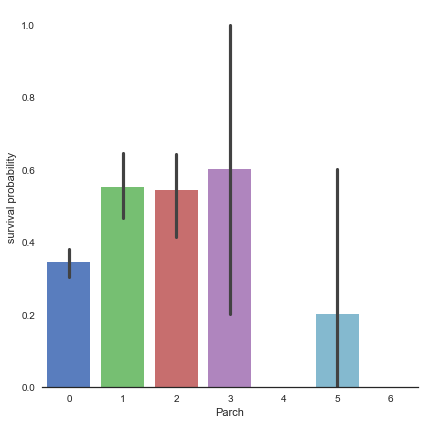

In [12]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

### Numerical values - Age

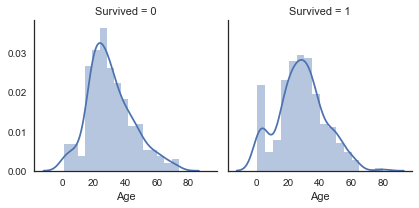

In [13]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

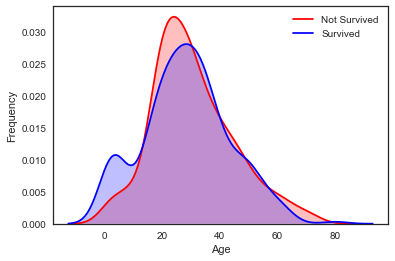

In [14]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

### Numerical values - Fare

In [15]:
dataset["Fare"].isnull().sum()

1

In [16]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

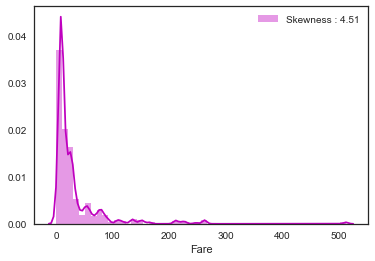

In [17]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [18]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

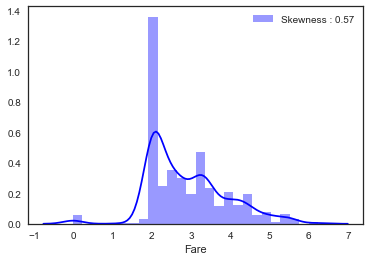

In [19]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

### Categorical values - Sex

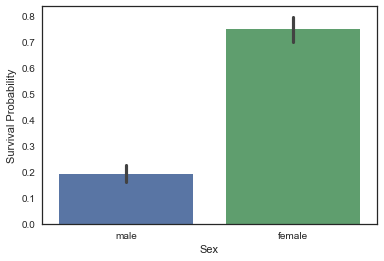

In [20]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [21]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


In [22]:
train[["Sex","Survived"]].groupby('Sex').std()

,Survived
Sex,
female,0.435110
male,0.393086


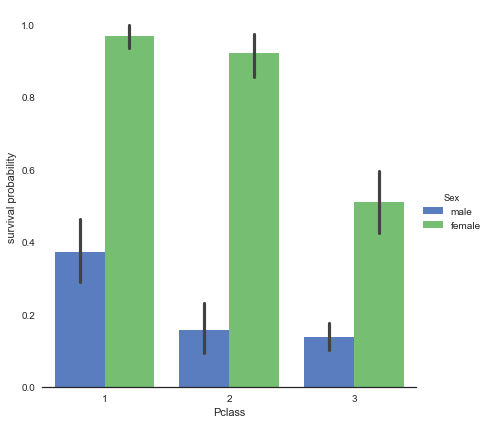

In [23]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [24]:
train[["Pclass", "Sex","Survived"]].groupby(["Pclass", "Sex"]).mean()

Survived
Pclass Sex             
1      female  0.967391
       male    0.371901
2      female  0.921053
       male    0.157407
3      female  0.510638
       male    0.137026

### Categorical values - Embarked

In [25]:
dataset["Embarked"].isnull().sum()

2

In [26]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

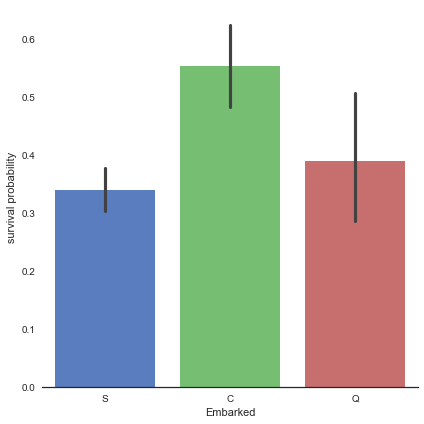

In [27]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

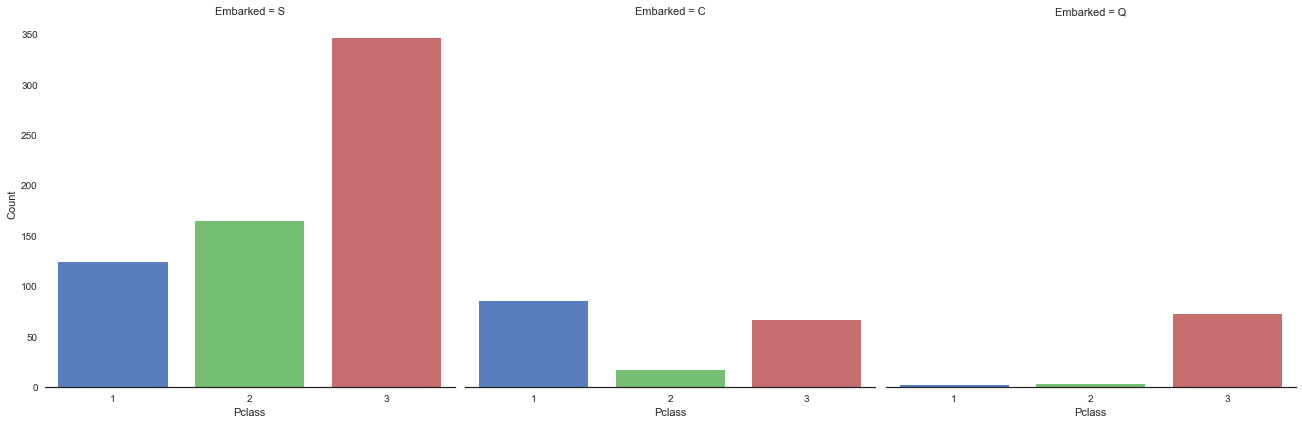

In [28]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

## Filling missing Values

### Filling missing Values - Age

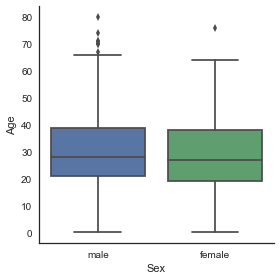

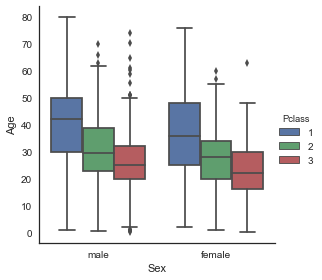

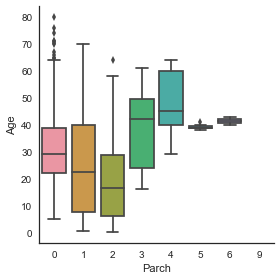

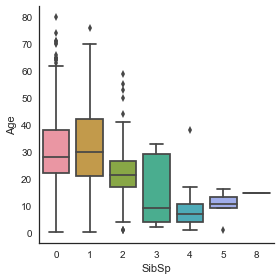

In [29]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

In [30]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

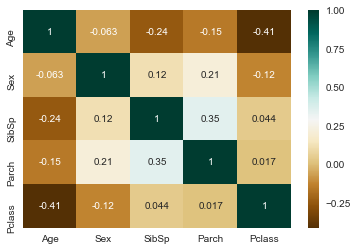

In [31]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [43]:
for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][(
            (dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (
            dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

D:\Anaconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


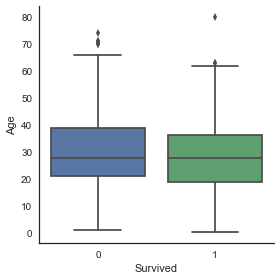

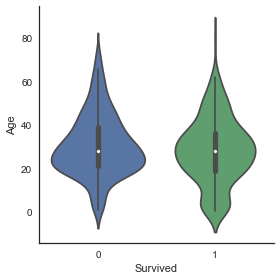

In [44]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

In [46]:
train[["Survived","Age"]].groupby('Survived').median()

,Age
Survived,
0,28.0
1,28.0


## Feature engineering

### Feature engineering - Name/Title

In [47]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [48]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

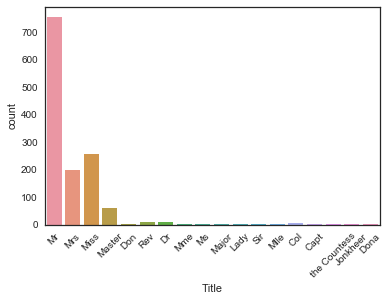

In [49]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [50]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

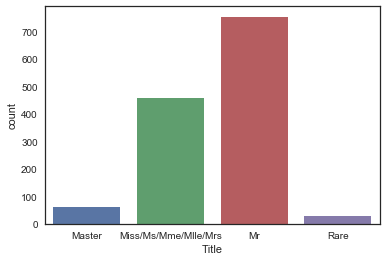

In [51]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

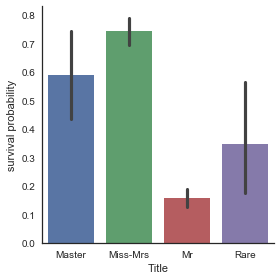

In [52]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [53]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### Feature engineering - Family size

In [54]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

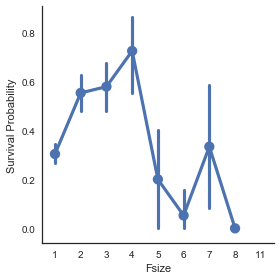

In [57]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [59]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

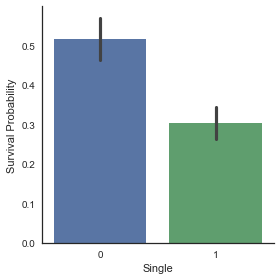

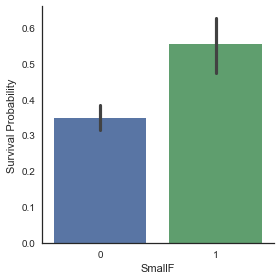

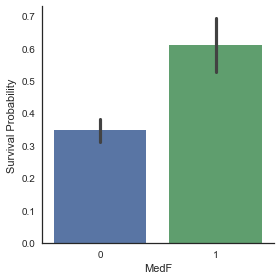

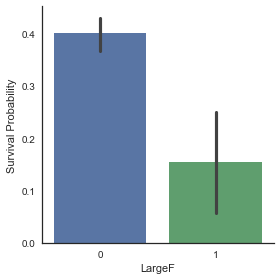

In [60]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [62]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [63]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


### Feature engineering - Cabin

In [64]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [65]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [66]:
dataset["Cabin"].isnull().sum()

1007

In [67]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [68]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

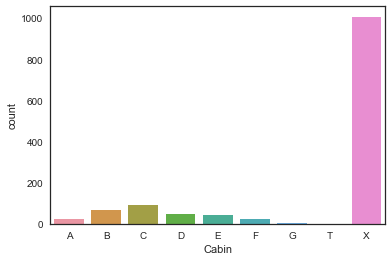

In [69]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

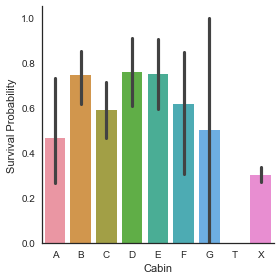

In [71]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [72]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### Feature engineering - Ticket

In [73]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [74]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [75]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [76]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [77]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [78]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [89]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
train["Survived"] = train["Survived"].astype(int)
test.drop(labels=["Survived"],axis = 1,inplace=True)

D:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
